<a href="https://colab.research.google.com/github/nascimento-luciano/Artificial-Intelligence/blob/master/Completo_COVID_19_Mercosul_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [349]:
#---------------------------------Etapa 1--------------------------------------
#Importanto bibliotecas

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#import geopandas as gpd -----> Verificar porque não carrega a biblioteca
import plotly.express as px
import plotly.graph_objects as go

In [350]:
#Importação da biblioteca geopandas via instalação no Colab
!pip install geopandas

In [351]:
#---------------------------------Etapa 2--------------------------------------
#Importando Arquivo CSV
#Dados não "Oficiais"
covid_cases = pd.read_csv('worldometer_coronavirus_daily_data.csv')
covid_vaxxs = pd.read_csv('country_vaccinations.csv')
df = pd.read_csv('covid_19_data.csv')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sub=pd.read_csv('submission.csv')
submission=pd.read_csv('submission.csv')
confirmed_df = pd.read_csv('time_series_covid_19_confirmed.csv')

#train['Date'] = pd.to_datetime(train['Date'])
#test['Date'] = pd.to_datetime(test['Date'])


In [352]:
#---------------------------------Etapa 3--------------------------------------
#Vamos marcar o datase e usar como amostra os países do Mercosul: Brazil, Argentina, Paraguay e Uruguay

def fix_country_name(country):
    name_dict = {
        'BRA': 'Brazil',
        'ARG': 'Argentina',
        'PRY': 'Paraguay',
        'URY': 'Uruguay'
     }
    try:
      return name_dict[country]
    except KeyError:
      return country

covid_cases.country = covid_cases.country.apply(fix_country_name)

In [353]:
#---------------------------------Etapa 4--------------------------------------
#Vamos observar esses 4 países
countries_of_interest = ["Brazil", "Argentina", "Paraguay", "Uruguay"]

#Vamos começar a limpar os dados filtrando-os para o subconjunto de países que desejamos.
covid_cases_subset = covid_cases[covid_cases.country.isin (countries_of_interest)]
covid_vaxxs_subset = covid_vaxxs[covid_vaxxs.country.isin (countries_of_interest)]

In [354]:
#---------------------------------Etapa 5--------------------------------------
#Unindo os databases usando as datas e países
   
merged_data = pd.merge_ordered(covid_cases_subset, covid_vaxxs_subset, \
                               left_on=['date', 'country'], \
                               right_on=['date', 'country'])

#Remove as colunas desnecessárias
merged_data.drop(columns=['iso_code', 'source_name', 'source_website', 'vaccines',\
                           'daily_vaccinations_per_million', 'daily_vaccinations_raw'], inplace=True)

In [355]:
#---------------------------------Etapa 6--------------------------------------
#Vamos lidar com os NaNs
merged_data.fillna({'total_vaccinations':0, 'people_vaccinated':0, 'people_fully_vaccinated':0,\
                 'daily_vaccinations':0,'total_vaccinations_per_hundred':0,\
                 'people_vaccinated_per_hundred':0 ,'people_fully_vaccinated_per_hundred':0}\
                 ,inplace=True)

covid_data = merged_data.dropna(how='any', subset=['cumulative_total_cases'])

In [356]:
#---------------------------------Etapa 7--------------------------------------
#Vamos também definir o índice para a data
covid_data.set_index('date', inplace=True)

In [357]:
#Vamos mudar o índice para um objeto datetime agora
covid_data.index = pd.to_datetime(covid_data.index, errors='coerce', infer_datetime_format=True)

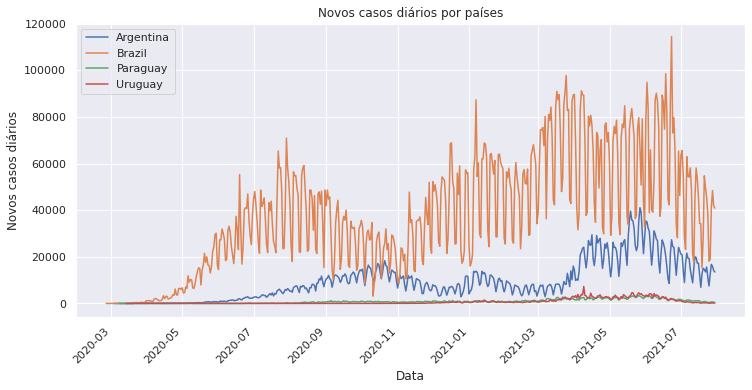

In [358]:
#---------------------------------Etapa 8--------------------------------------
#Taxas de infecção nos países do Mercosul
plt.figure(figsize=(12, 6))
covid_data.groupby('country').daily_new_cases.plot(legend=True,rot=45)

plt.ylabel('Novos casos diários')
plt.xlabel('Data')
plt.title('Novos casos diários por países');

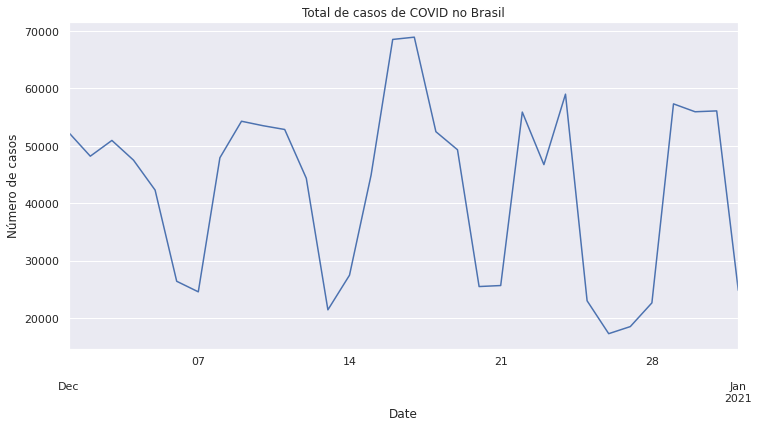

In [359]:
#---------------------------------Etapa 9--------------------------------------
#Agora vamos ampliar o gráfico e observar o padrão. [17/01/2021 - Refere-se a primeira pessoa vacinada no Brasil]
week_intervals = ['17/01/2021','24/01/2021','31/01/2021','07/02/2021']

plt.figure(figsize=(12, 6))
covid_data[covid_data.country == 'Brazil'] \
  .loc['12/1/2020':'1/1/2021'].daily_new_cases.plot()

{plt.axvline(d, color='k', linestyle='dashed', linewidth=1) for d in week_intervals}

plt.ylabel('Número de casos')
plt.xlabel('Date')
plt.title('Total de casos de COVID no Brasil');

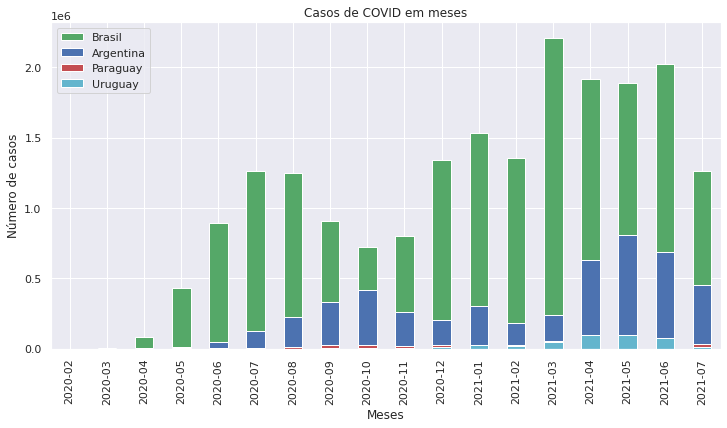

In [360]:
#---------------------------------Etapa 10--------------------------------------
#A época do ano é importante para infecções?
BRA_infections = covid_data[covid_data.country == 'Brazil']
ARG_infections = covid_data[covid_data.country == 'Argentina']
PRY_infections = covid_data[covid_data.country == 'Paraguay']
URY_infections = covid_data[covid_data.country == 'Uruguay']

plt.figure(figsize=(12, 6))
BRA_infections['daily_new_cases']\
  .groupby(BRA_infections.index.to_period('M'))\
  .sum().plot(kind='bar', legend=False, color='g')

ARG_infections['daily_new_cases']\
 .groupby(ARG_infections.index.to_period('M'))\
 .sum().plot(kind='bar', legend=False, color='b')

PRY_infections['daily_new_cases']\
 .groupby(ARG_infections.index.to_period('M'))\
 .sum().plot(kind='bar', legend=False, color='r')

URY_infections['daily_new_cases']\
 .groupby(ARG_infections.index.to_period('M'))\
 .sum().plot(kind='bar', legend=False, color='c')

plt.legend(['Brasil', 'Argentina', 'Paraguay', 'Uruguay'])
plt.ylabel('Número de casos')
plt.xlabel('Meses')
plt.title('Casos de COVID em meses');

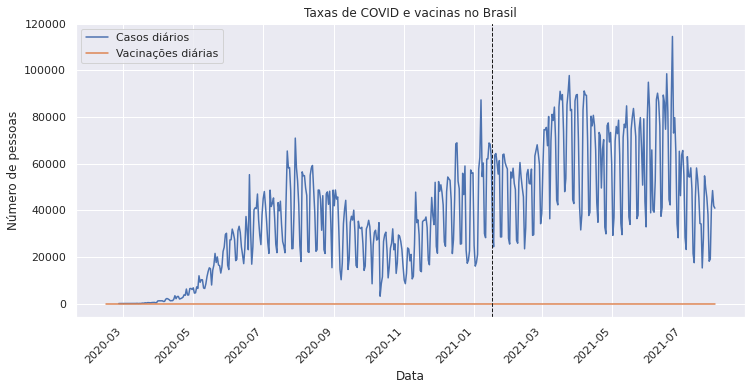

In [361]:
#---------------------------------Etapa 11--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(12, 6))
covid_data[covid_data.country == 'Brazil'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Brazil'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina  -----> Mônica Calazans (Primeiro Vacinado)
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Brasil');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Brazil
#https://ourworldindata.org/coronavirus/country/brazil

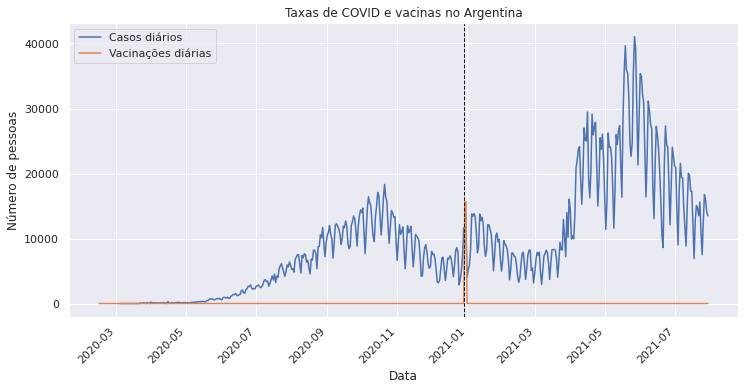

In [362]:
#---------------------------------Etapa 12--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(12, 6))
covid_data[covid_data.country == 'Argentina'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Argentina'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina -----> Flavia Loiacono (Primeiro Vacinado)
plt.axvline('29/12/2020', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Argentina');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Argentina
#https://ourworldindata.org/coronavirus/country/argentina

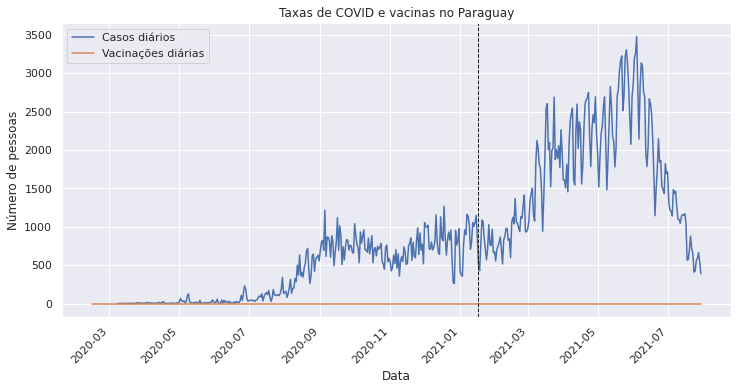

In [363]:
#---------------------------------Etapa 13--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(12, 6))
covid_data[covid_data.country == 'Paraguay'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Paraguay'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Paraguay');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Paraguay
#https://ourworldindata.org/coronavirus/country/paraguay

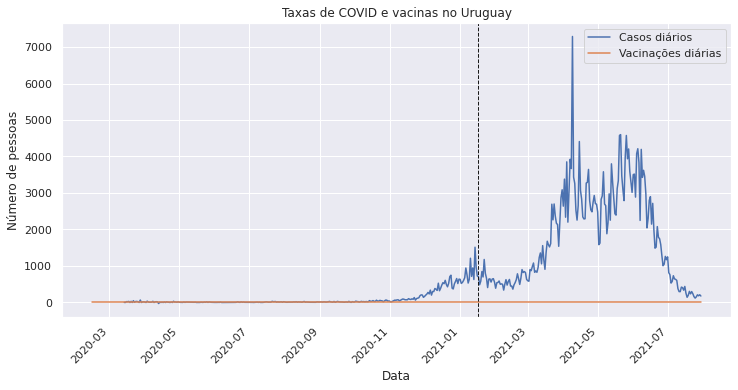

In [364]:
#---------------------------------Etapa 14--------------------------------------
#Vemos que o padrão muda de país para país
plt.figure(figsize=(12, 6))
covid_data[covid_data.country == 'Uruguay'].daily_new_cases.plot(legend=False,rot=45)
covid_data[covid_data.country == 'Uruguay'].daily_vaccinations.plot(legend=False,rot=45)

#Marque o início do lançamento da vacina
plt.axvline('17/01/2021', color='k', linestyle='dashed', linewidth=1)

plt.legend(['Casos diários', 'Vacinações diárias'])
plt.ylabel('Número de pessoas')
plt.xlabel('Data')
plt.title('Taxas de COVID e vacinas no Uruguay');

#É possível conferir se os gráficos abaixo estão certo,
#checando nos sites da Wikipedia e Our World Data
#https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Uruguay
#https://ourworldindata.org/coronavirus/country/uruguay

--------------------------Fim do Código---------------------------------------

2ª Parte - Plotagem do Modelo de Predição da Covid no Brasil

In [365]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
#import squarify
import plotly.offline as py
#import plotly_express as px

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

In [366]:
#Importação da biblioteca squarify via instalação no Colab
!pip install squarify
#!pip install plotly.offline
!pip install plotly_express

In [367]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


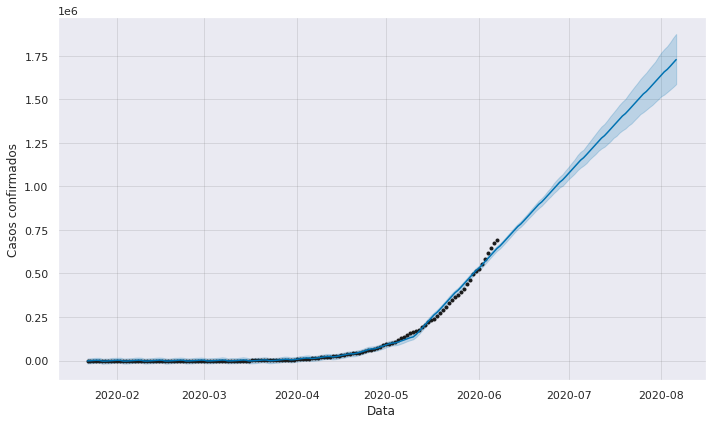

In [368]:
#Predição usando Prophet Model 
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
k = df1[df1['Country/Region']=='Brazil'].loc[:,'1/22/20':]
brazil_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = brazil_confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=60)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(60)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Data',ylabel='Casos confirmados')

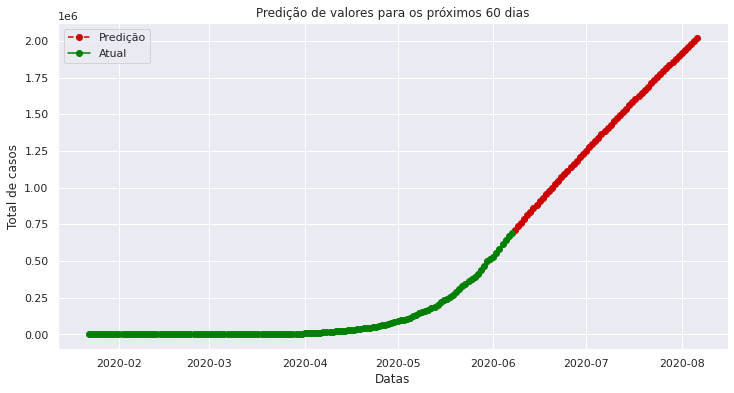

In [369]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 60)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(60):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (12,6))
plt.xlabel("Datas",fontsize = 12)
plt.ylabel('Total de casos',fontsize = 12)
plt.title("Predição de valores para os próximos 60 dias" , fontsize = 12)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#cc0000',label = 'Predição');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'green',label = 'Atual');
plt.legend();


In [370]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')


In [371]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [372]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              35995 non-null  int64  
 1   Province_State  15295 non-null  object 
 2   Country_Region  35995 non-null  object 
 3   Date            35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ MB


In [373]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [374]:
train.columns

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities'],
      dtype='object')

In [375]:
# Deaths bigger than 10.000 and ConfirmedCases higher than 100.000 
train[(train['Fatalities']>10000) & (train['ConfirmedCases']>100000) ]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
3557,3558,NaN,Brazil,2020-05-08,146894.0,10017.0
3558,3559,NaN,Brazil,2020-05-09,156061.0,10656.0
3559,3560,NaN,Brazil,2020-05-10,162699.0,11123.0
3560,3561,NaN,Brazil,2020-05-11,169594.0,11653.0
3561,3562,NaN,Brazil,2020-05-12,178214.0,12461.0
...,...,...,...,...,...,...
35070,35071,NaN,United Kingdom,2020-05-11,223060.0,32065.0
35071,35072,NaN,United Kingdom,2020-05-12,226463.0,32692.0
35072,35073,NaN,United Kingdom,2020-05-13,229705.0,33186.0
35073,35074,NaN,United Kingdom,2020-05-14,233151.0,33614.0


[[343676.76555961]]
[[301673.03748261]]


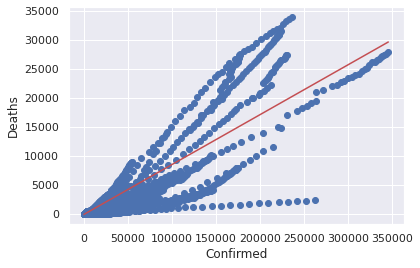

In [376]:
confirmed_value = train.ConfirmedCases.values.reshape(-1,1)
dead_value = train.Fatalities.values.reshape(-1,1)

regression = LinearRegression()
regression.fit(confirmed_value,dead_value)

print(regression.predict([[4000000]]).reshape(-1,1))

print(regression.predict([[3511229]]).reshape(-1,1))
plt.scatter(train.ConfirmedCases,train.Fatalities)

x = np.arange(min(train.ConfirmedCases),max(train.ConfirmedCases)).reshape(-1,1)

plt.plot(x,regression.predict(x),color="r")

plt.xlabel('Confirmed')
plt.ylabel('Deaths')
plt.show()

In [377]:
print(r2_score(dead_value,regression.predict(confirmed_value)))
# 0.80 very good accuracy i think

0.7924415719935288


In [378]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [379]:
train.columns

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities'],
      dtype='object')

In [380]:
Deaths_data = train.iloc[:,5].values.reshape(-1,1)

Confirmed_data = train.iloc[:,4].values.reshape(-1,1)

In [381]:
Poly_regression = PolynomialFeatures(degree = 4)

Deaths_data_poly = Poly_regression.fit_transform(Deaths_data)

In [382]:
regression2 = LinearRegression() 
regression2.fit(Deaths_data_poly,Confirmed_data)

LinearRegression()

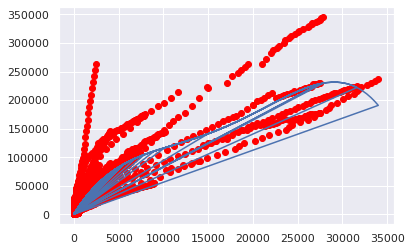

In [383]:
plt.scatter(Deaths_data,Confirmed_data,color='red')
plt.plot(Deaths_data,regression2.predict(Deaths_data_poly))

plt.show()

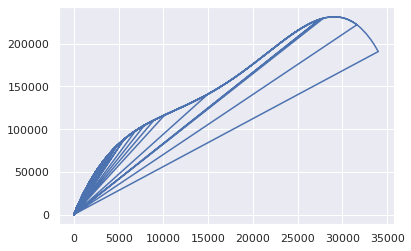

In [384]:
plt.plot(Deaths_data,regression2.predict(Deaths_data_poly))

plt.show()

In [385]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import bokeh 
from bokeh.io import output_notebook
from bokeh.resources import INLINE
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
output_notebook(resources=INLINE)
%matplotlib inline

In [386]:
#!pip install MinMaxScaler

In [387]:
train = pd.DataFrame(pd.read_csv('train.csv'))

In [388]:
print("The shape of training data is = {}".format(train.shape))

The shape of training data is = (35995, 6)


In [389]:
train.Province_State.fillna("", inplace = True)
train.ConfirmedCases.fillna("", inplace = True)
train.Fatalities.fillna("", inplace = True)

In [390]:
train["Country_Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guinea', 'Guine

In [391]:
confirmed_cases_brazil = train[train["Country_Region"] == "Brazil"].groupby(["Date"]).ConfirmedCases.sum()
fatal_cases_brazil = train[train["Country_Region"] == "Brazil"].groupby(["Date"]).Fatalities.sum()

In [392]:
train_brazil = train[train["Country_Region"] == "Brazil"]
train_brazil

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
3450,3451,,Brazil,2020-01-22,0.0,0.0
3451,3452,,Brazil,2020-01-23,0.0,0.0
3452,3453,,Brazil,2020-01-24,0.0,0.0
3453,3454,,Brazil,2020-01-25,0.0,0.0
3454,3455,,Brazil,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
3560,3561,,Brazil,2020-05-11,169594.0,11653.0
3561,3562,,Brazil,2020-05-12,178214.0,12461.0
3562,3563,,Brazil,2020-05-13,190137.0,13240.0
3563,3564,,Brazil,2020-05-14,203165.0,13999.0


In [393]:
train_brazil["ConfirmedCases"] = train_brazil["ConfirmedCases"].astype(int)
train_brazil["Fatalities"] = train_brazil["Fatalities"].astype(int)

In [394]:
train_brazil_size = int(len(train_brazil) * 0.75)
val_brazil_size = len(train_brazil) - train_brazil_size
print("Training size = {}".format(train_brazil_size))
print("Validation size = {}".format(val_brazil_size))

Training size = 86
Validation size = 29


In [395]:
train_brazil_confirmed_cases = train_brazil[["ConfirmedCases"]]
train_brazil_fatal_cases = train_brazil[["Fatalities"]]

In [396]:
print(train_brazil_confirmed_cases, train_brazil_fatal_cases)

      ConfirmedCases
3450               0
3451               0
3452               0
3453               0
3454               0
...              ...
3560          169594
3561          178214
3562          190137
3563          203165
3564          220291

[115 rows x 1 columns]       Fatalities
3450           0
3451           0
3452           0
3453           0
3454           0
...          ...
3560       11653
3561       12461
3562       13240
3563       13999
3564       14962

[115 rows x 1 columns]


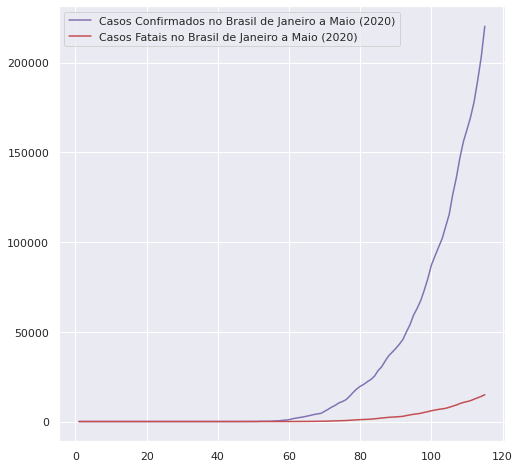

In [421]:
plt.figure(figsize = (8, 8))
x = np.arange(1, 116, 1)
y1 = train_brazil_confirmed_cases 
y2 = train_brazil_fatal_cases 
plt.plot(x, y1, color = "m", label = "Casos Confirmados no Brasil de Janeiro a Maio (2020)")
plt.plot(x, y2, color = "r", label = "Casos Fatais no Brasil de Janeiro a Maio (2020)")
plt.grid(True)
plt.legend()

In [398]:
len(train_brazil_confirmed_cases)

115

In [399]:
train_brazil_confirmed_cases

,ConfirmedCases
3450,0
3451,0
3452,0
3453,0
3454,0
...,...
3560,169594
3561,178214
3562,190137
3563,203165


In [400]:
train_brazil_confirmed_cases_data = train_brazil_confirmed_cases.iloc[0:train_brazil_size]
val_brazil_confirmed_cases_data = train_brazil_confirmed_cases.iloc[train_brazil_size : len(train_brazil_confirmed_cases)]

In [401]:
print(len(train_brazil_confirmed_cases_data))
print(len(val_brazil_confirmed_cases_data))

86
29


In [402]:
scaler = MinMaxScaler(feature_range = (0,1))
def createDataset(train) : 
    train_scaled = scaler.fit_transform(train)
    x_train = [] 
    y_train = []
    time_step = 2
    for i in range(time_step, train_scaled.shape[0]):
        x_train.append(train_scaled[i-time_step : i , 0])
        y_train.append(train_scaled[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
    y_train = np.reshape(y_train, (y_train.shape[0], 1 ))
    return x_train, y_train     

In [403]:
def createDataset(train) : 
    train_scaled = scaler.fit_transform(train)
    x_train = [] 
    y_train = []
    time_step = 2
    for i in range(time_step, train_scaled.shape[0]):
        x_train.append(train_scaled[i-time_step : i , 0])
        y_train.append(train_scaled[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
    y_train = np.reshape(y_train, (y_train.shape[0], 1 ))
    return x_train, y_train   

In [404]:
x_train, y_train = createDataset(train_brazil_confirmed_cases_data)
x_val, y_val = createDataset(val_brazil_confirmed_cases_data)

In [405]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(84, 2, 1) (84, 1)
(27, 2, 1) (27, 1)


In [406]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units = 1))

In [407]:
model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")

In [408]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 50)             10400     
                                                                 
 dropout_18 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_19 (LSTM)              (None, 2, 50)             20200     
                                                                 
 dropout_19 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_20 (LSTM)              (None, 2, 50)             20200     
                                                                 
 dropout_20 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_21 (LSTM)              (None, 50)               

In [409]:
EPOCHS = 200
BATCH_SIZE = 1

In [410]:
with tf.device("/device:GPU:0"):
  history = model.fit(x_train, y_train,epochs = EPOCHS, verbose = 1,
                     batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/200
84/84 [==============================] - 8s 29ms/step - loss: 0.0624 - val_loss: 0.1352
Epoch 2/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0400 - val_loss: 0.0029
Epoch 3/200
84/84 [==============================] - 1s 8ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 4/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0109
Epoch 5/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 6/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 7/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 8/200
84/84 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0117
Epoch 9/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0134
Epoch 10/200
84/84 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 11

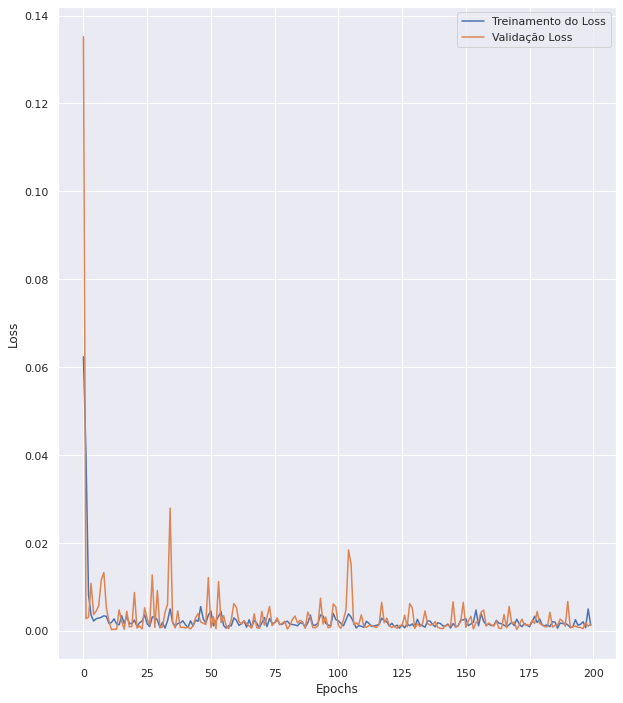

In [418]:
x = np.arange(0, EPOCHS, 1)                                                                  
plt.figure(1, figsize = (22, 12))                                  
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, history.history["loss"], label = "Treinamento do Loss")
plt.plot(x, history.history["val_loss"], label = "Validação Loss")
plt.grid(True)
plt.legend()  

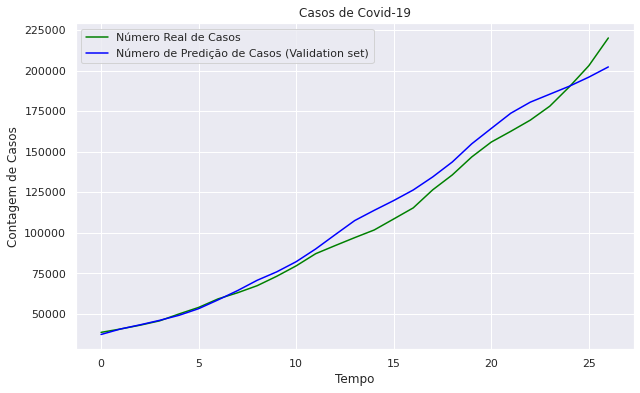

In [417]:
predicted_cases = model.predict(x_val)
predicted_cases = scaler.inverse_transform(predicted_cases)
real_cases = scaler.inverse_transform(y_val)
plt.figure(figsize= (10, 6))
plt.subplot(1,1,1)
plt.plot(real_cases, color = "green", label = "Número Real de Casos")
plt.plot(predicted_cases, color = "blue", label = "Número de Predição de Casos (Validation set)")
plt.title("Casos de Covid-19")
plt.xlabel("Tempo")
plt.ylabel("Contagem de Casos")
plt.legend()
plt.grid("both")
plt.show()